In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
from paste.helper import to_dense_array
import anndata

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


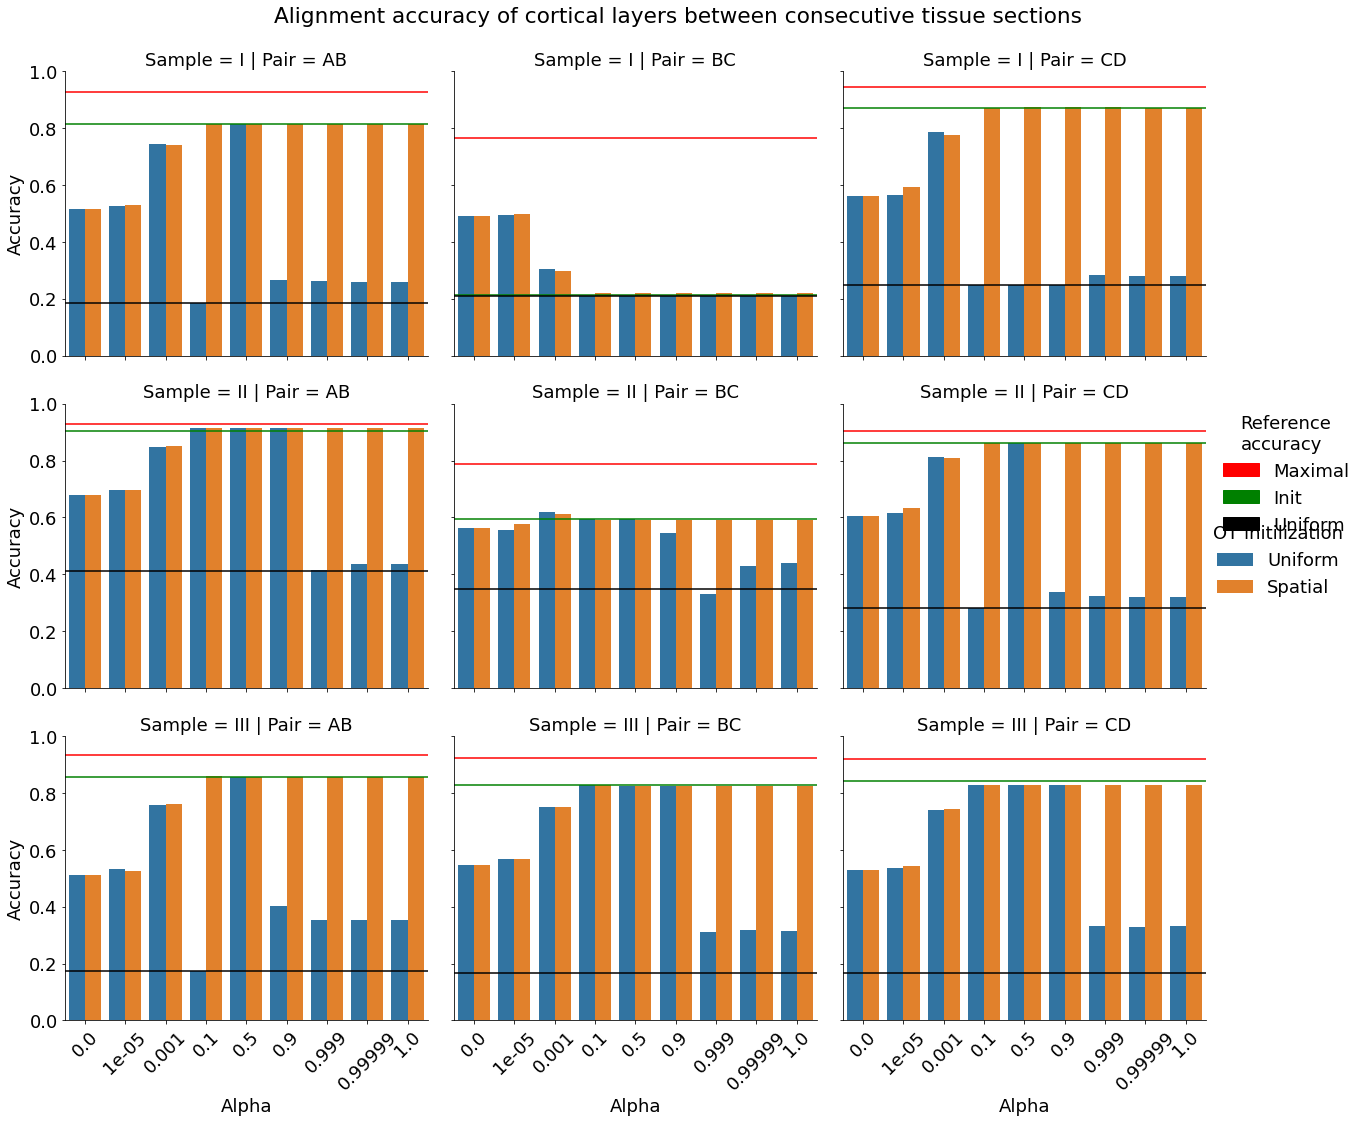

In [2]:
res_df = pd.read_csv('../data/DLPFC/saved_results/PASTE_pairwise_accuracy_results_objective.csv',index_col=0,sep=',')
res_df['type'] = res_df.apply(lambda x: str(x['alpha'])+' '+str(x['init']) if x['kind']=='PASTE' else x['kind'],axis=1)
sample_map,pair_map = {0:'I',1:'II',2:'III'},{0:'AB',1:'BC',2:'CD'}
res_df['sample'] = res_df['sample'].map(sample_map)
res_df['pair'] = res_df['pair'].map(pair_map)
res_df = res_df.rename(columns={'sample':'Sample','pair':'Pair'})
plt.rcParams.update({'font.size': 18})
g = sns.catplot(x="alpha", y="accuracy",hue='init',row='Sample', col="Pair",data=res_df[res_df['kind']=='PASTE'],kind="bar", ci=None, aspect=1,legend=False)
g.set_axis_labels("Alpha", "Accuracy").set(ylim=(0, 1))
g.add_legend(title='OT initilization',labels=['Uniform','Spatial'])
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Alignment accuracy of cortical layers between consecutive tissue sections')
for sample in sample_map:
    for pair in pair_map:
        temp = res_df[(res_df['Sample']==sample_map[sample])&(res_df['Pair']==pair_map[pair])]
        line_c = [('maximal','r'),('init','g'),('uniform','k')]
        for t,c in line_c:
            g.axes[sample,pair].axhline(float(temp[temp['kind']==t]['accuracy']), 0, 1,color=c)
        g.axes[sample,pair].set_xticklabels(g.axes[sample,pair].get_xticklabels(),rotation = 45)
g.add_legend(handles=[mpatches.Patch(color=line_c[i][1], label='{0}'.format(line_c[i][0].capitalize())) for i in range(len(line_c))],title='Reference\naccuracy',bbox_to_anchor=(1, 0.6))
# plt.gcf().suptitle('This is a somewhat long figure title', fontsize=16)

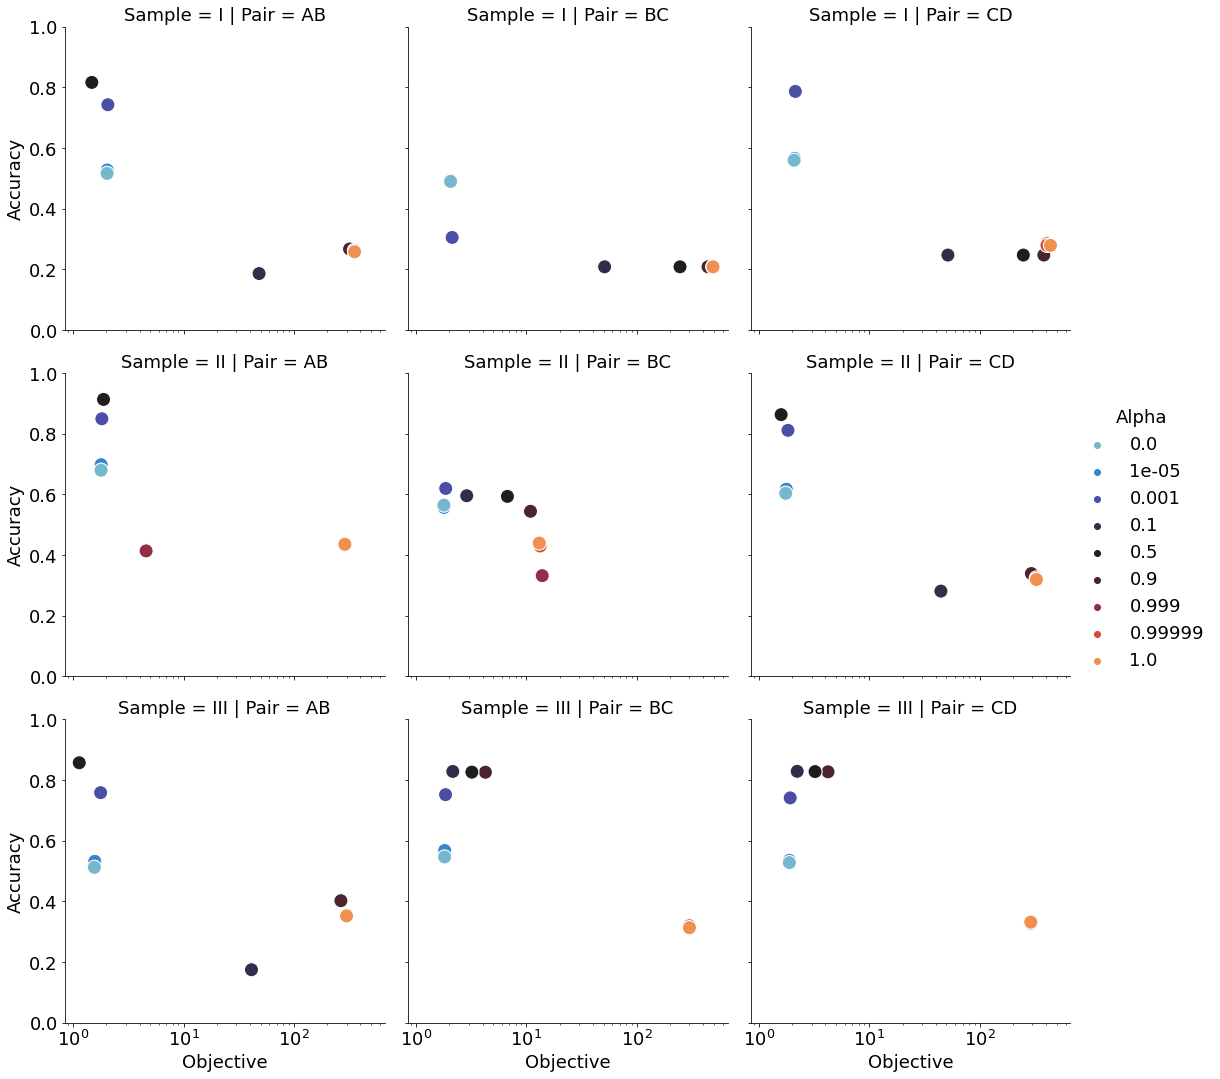

In [3]:
temp_res_df = res_df[(res_df['kind']=='PASTE') & (res_df['init']==False)].copy()
# temp_res_df = res_df[(res_df['kind']=='PASTE') & (res_df['init']==True)].copy()
temp_res_df['log obj'] = np.log(temp_res_df['Objective'])
temp_res_df['alpha'] = temp_res_df['alpha'].map(str)
temp_res_df = temp_res_df.rename(columns={'alpha':'Alpha','accuracy':'Accuracy'})
# g = sns.relplot(x="Objective", y="accuracy",row='Sample', col="Pair",hue="alpha",data=temp_res_df,kind='scatter',s=100)
g = sns.relplot(x="Objective", y="Accuracy",row='Sample', col="Pair",hue="Alpha",data=temp_res_df,kind='scatter',s=200,
                hue_order=list(map(str,sorted(map(float,pd.unique(temp_res_df['Alpha']))))),palette=sns.color_palette("icefire", 9))
g.set(xscale="log")
g.set_axis_labels("Objective", "Accuracy").set(ylim=(0, 1))

     sample  pair   kind        time  accuracy  init  alpha  Objective
140       0     0  PASTE  320.464646  0.815876  True  1.000   0.825963
142       0     1  PASTE   52.002840  0.489729  True  0.000   2.054982
42        0     2  PASTE  121.060369  0.872960  True  0.999   1.342773
154       1     0  PASTE   28.969592  0.679422  True  0.000   1.790039
160       1     1  PASTE   36.885888  0.564391  True  0.000   1.788018
170       1     2  PASTE  739.127670  0.861923  True  1.000   1.284996
176       2     0  PASTE  190.814396  0.856277  True  1.000   0.445236
178       2     1  PASTE   27.769902  0.546337  True  0.000   1.812511
184       2     2  PASTE   25.392260  0.527552  True  0.000   1.884273
     sample  pair   kind        time  accuracy   init    alpha  Objective
138       0     0  PASTE  260.361395  0.816127   True  0.50000   1.475734
19        0     1  PASTE   52.157727  0.498486   True  0.00001   2.059010
40        0     2  PASTE  120.614343  0.874065   True  0.90000   1.4

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


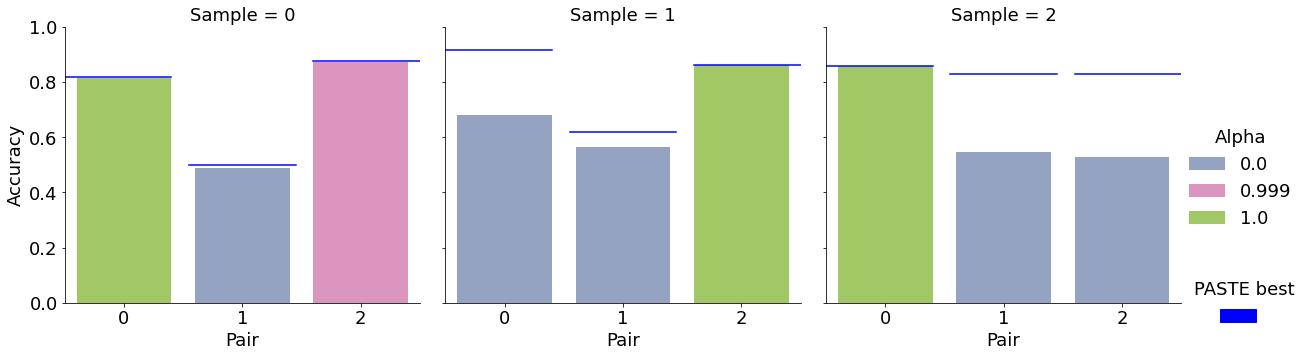

In [4]:
res_df = pd.read_csv('../data/DLPFC/saved_results/PASTE_pairwise_accuracy_results_objective.csv',index_col=0,sep=',')
res_df = res_df[res_df['kind']=='PASTE']
temp_df = res_df.sort_values('init',ascending=False).sort_values(['sample','pair'])

### CHANGE this line to togle between A and B
#temp_df = res_df[(res_df['alpha'].isin([0.1,0.5,0.9]))].copy()

temp_df = temp_df.loc[temp_df.groupby(['sample','pair']).Objective.idxmin()]
print(temp_df)
temp_df = temp_df.rename(columns={'sample':"Sample","pair":"Pair",'alpha':'Alpha','accuracy':'Accuracy'})
g = sns.catplot(x="Pair", y="Accuracy", col="Sample",hue="Alpha",data=temp_df, dodge=False,kind="bar", ci=None, aspect=1,legend=True,palette=sns.color_palette("Set2")[2:])
g.set_axis_labels("Pair", "Accuracy").set(ylim=(0, 1))
temp_df = res_df[res_df['kind']=='PASTE'].copy()
temp_df = temp_df.loc[temp_df.groupby(['sample','pair']).accuracy.idxmax()]
print(temp_df)
for j in range(3):
    for i in range(3):
        g.axes[0][j].axhline(float(temp_df[(temp_df['sample']==j)&(temp_df['pair']==i)]['accuracy']), 0.35*i, 0.35*i+0.3,color='b')
g.add_legend(handles=[mpatches.Patch(color='b')],title='PASTE best',bbox_to_anchor=(1, 0.15))

     sample  pair   kind         time  accuracy   init  alpha  Objective
10        0     0  PASTE   346.027446  0.815877   True    0.9   0.956120
23        0     1  PASTE    75.565319  0.219817   True    0.1   2.634956
40        0     2  PASTE   120.614343  0.874065   True    0.9   1.424924
52        1     0  PASTE   839.407099  0.915011  False    0.1   1.870246
68        1     1  PASTE    51.656278  0.591388   True    0.1   2.857556
85        1     2  PASTE  1330.450951  0.861824   True    0.9   1.344966
100       2     0  PASTE   273.862379  0.856461   True    0.9   0.583261
112       2     1  PASTE   518.168246  0.828177  False    0.1   2.151991
127       2     2  PASTE   357.696834  0.828471  False    0.1   2.219591
     sample  pair   kind        time  accuracy   init    alpha  Objective
138       0     0  PASTE  260.361395  0.816127   True  0.50000   1.475734
19        0     1  PASTE   52.157727  0.498486   True  0.00001   2.059010
40        0     2  PASTE  120.614343  0.874065  

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


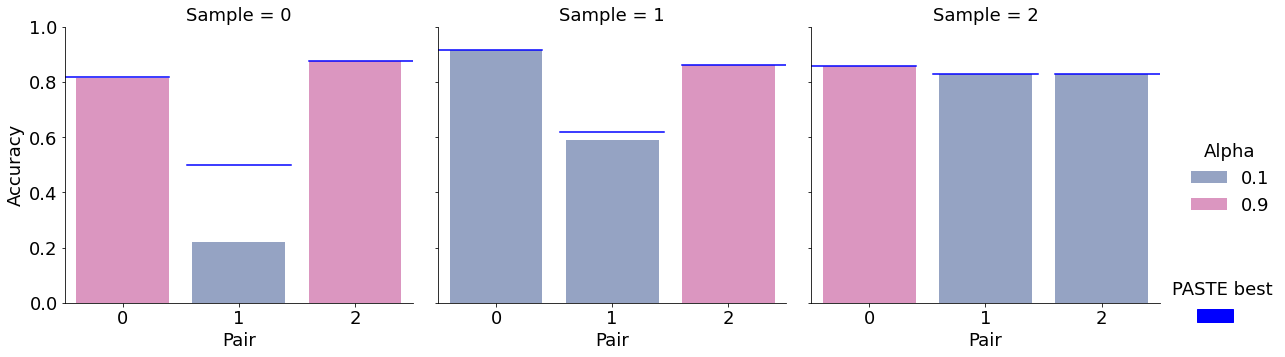

In [5]:
res_df = pd.read_csv('../data/DLPFC/saved_results/PASTE_pairwise_accuracy_results_objective.csv',index_col=0,sep=',')
res_df = res_df[res_df['kind']=='PASTE']
temp_df = res_df.sort_values('init',ascending=False).sort_values(['sample','pair'])

### CHANGE this line to togle between A and B
temp_df = res_df[(res_df['alpha'].isin([0.1,0.5,0.9]))].copy()

temp_df = temp_df.loc[temp_df.groupby(['sample','pair']).Objective.idxmin()]
print(temp_df)
temp_df = temp_df.rename(columns={'sample':"Sample","pair":"Pair",'alpha':'Alpha','accuracy':'Accuracy'})
g = sns.catplot(x="Pair", y="Accuracy", col="Sample",hue="Alpha",data=temp_df, dodge=False,kind="bar", ci=None, aspect=1,legend=True,palette=sns.color_palette("Set2")[2:])
g.set_axis_labels("Pair", "Accuracy").set(ylim=(0, 1))
temp_df = res_df[res_df['kind']=='PASTE'].copy()
temp_df = temp_df.loc[temp_df.groupby(['sample','pair']).accuracy.idxmax()]
print(temp_df)
for j in range(3):
    for i in range(3):
        g.axes[0][j].axhline(float(temp_df[(temp_df['sample']==j)&(temp_df['pair']==i)]['accuracy']), 0.35*i, 0.35*i+0.3,color='b')
g.add_legend(handles=[mpatches.Patch(color='b')],title='PASTE best',bbox_to_anchor=(1, 0.15))